# Content <-> audience

In [53]:
import numpy as np
import pandas as pd
import warnings

from itertools import product
from tqdm import tqdm

from scipy import stats

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [55]:
warnings.simplefilter('ignore')

In [56]:
dfc = pd.read_json('data/hl-graph.json', lines=True)

In [57]:
dfa = pd.read_json('data/user-graph.json', lines=True)

In [58]:
DOMAINS = dfc.d1.unique()

In [59]:
C_METRICS = sorted(set(dfc.columns) - {'d1', 'd2'})

In [60]:
A_METRICS = sorted(set(dfa.columns) - {'d1', 'd2'})

In [61]:
def plot_domain_content(domain, title=None, dst=None):
    
    pdf = dfc[dfc.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], C_METRICS)
    
    plt.figure(figsize=(5,10), dpi=100)
    
    if title:
        plt.title(title)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')
    
    plt.show()

In [62]:
def plot_domain_audience(domain, title=None, dst=None):
    
    pdf = dfa[dfa.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], A_METRICS)

    plt.figure(figsize=(5,10), dpi=100)
    
    if title:
        plt.title(title)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')

    plt.show()

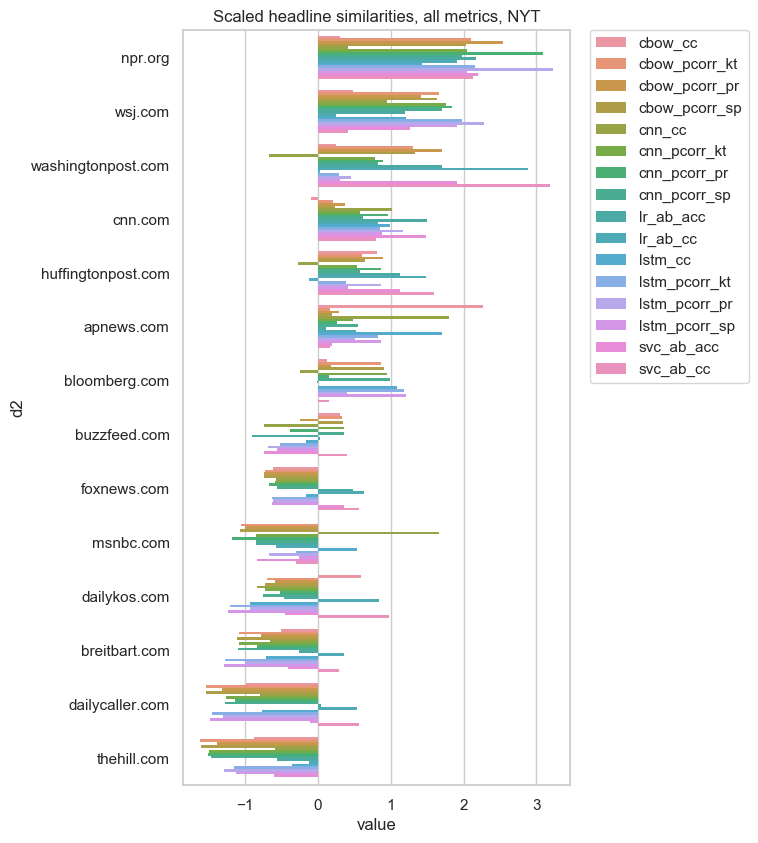

In [63]:
plot_domain_content('nytimes.com', 'Scaled headline similarities, all metrics, NYT', 'figures/ca-nyt-content.png')

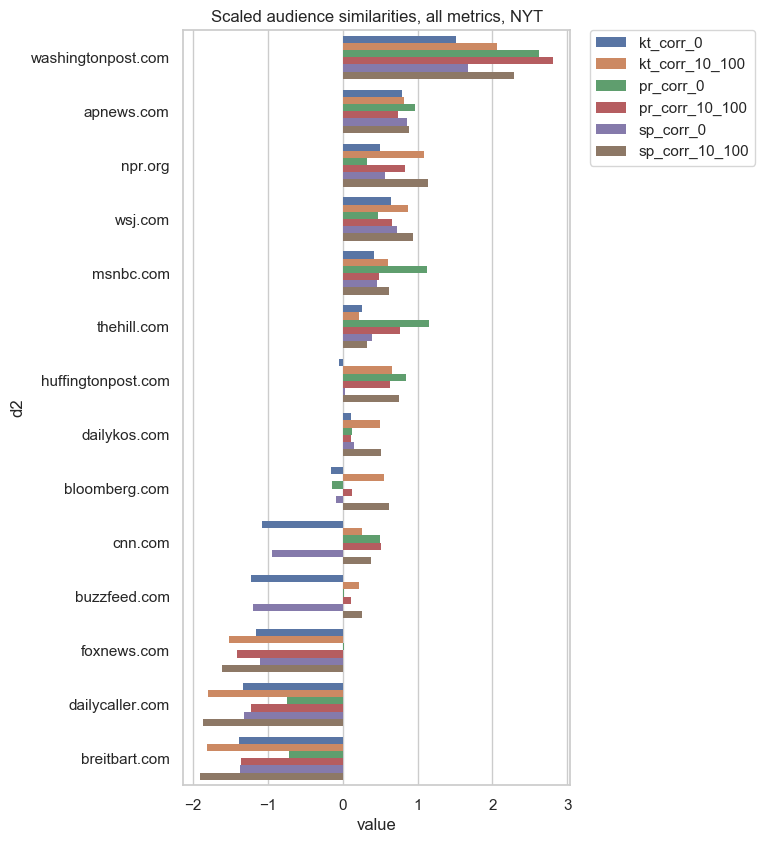

In [64]:
plot_domain_audience('nytimes.com', 'Scaled audience similarities, all metrics, NYT', 'figures/ca-nyt-audience.png')

In [65]:
def ca_corr(domain, c_metric, a_metric, plot=False):
    
    ddfc = dfc[dfc.d1==domain][['d2', c_metric]]
    ddfa = dfa[dfa.d1==domain][['d2', a_metric]]
    
    ddf = ddfc.merge(ddfa)
    
    if plot:
        ddf_melt = ddf.melt('d2', [c_metric, a_metric])
        order = ddf.sort_values(c_metric, ascending=False).d2
        plt.figure(figsize=(4,5))
        sns.barplot(y='d2', x='value', hue='variable', data=ddf_melt, order=order)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    return stats.kendalltau(ddf[c_metric], ddf[a_metric])

In [66]:
rows = []
for d, cm, am in tqdm(product(DOMAINS, C_METRICS, A_METRICS)):
    corr, p = ca_corr(d, cm, am)
    rows.append((d, cm, am, corr, p))

1440it [00:06, 211.18it/s]


In [67]:
corr_df = pd.DataFrame(rows, columns=('domain', 'cm', 'am', 'corr', 'p'))

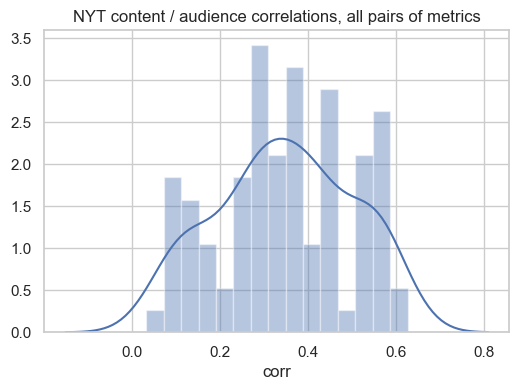

In [68]:
plt.figure(figsize=(6,4), dpi=100)
plt.title('NYT content / audience correlations, all pairs of metrics')
sns.distplot(corr_df[corr_df.domain=='nytimes.com']['corr'], bins=15)
plt.savefig('figures/nyt-corr-dist.png', bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

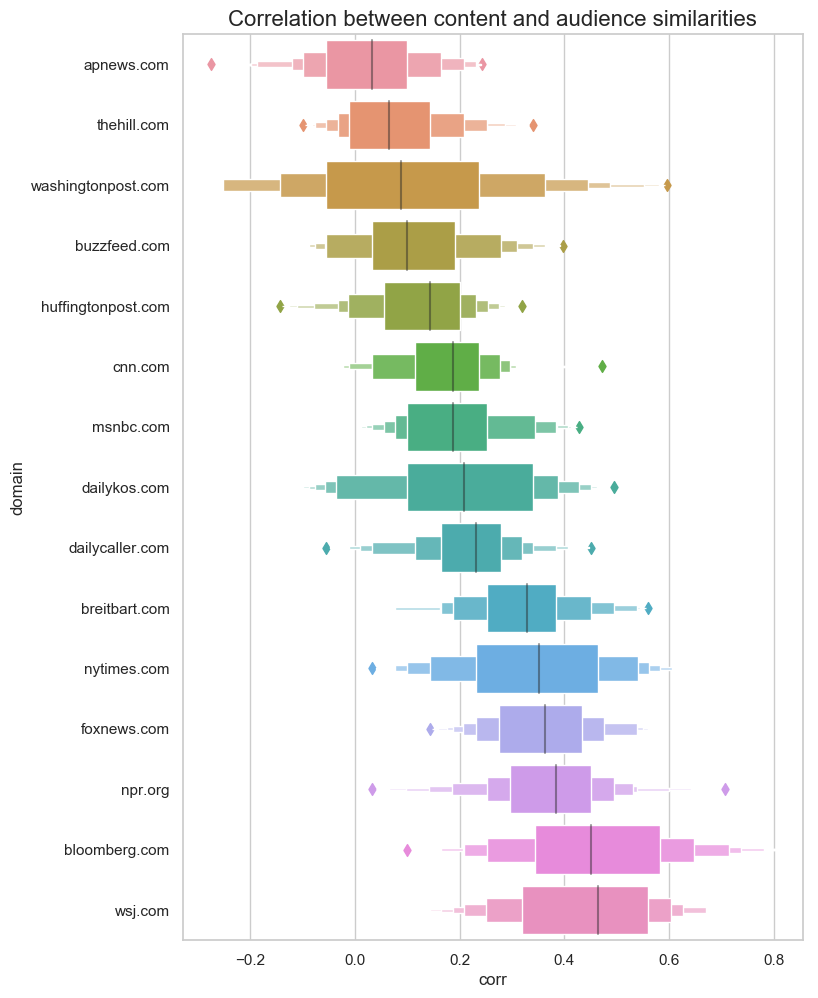

In [69]:
order = corr_df.groupby('domain').median().sort_values('corr').index
plt.figure(figsize=(8,12), dpi=100)
plt.title('Correlation between content and audience similarities', fontsize=16)
sns.boxenplot(x='corr', y='domain', data=corr_df, order=order)
plt.savefig('figures/ca-corr.png', bbox_inches='tight')

In [70]:
def plot_ac(domain, dst=None):
    
    ddfc = dfc[dfc.d1==domain]
    ddfa = dfa[dfa.d1==domain]
    ddf = ddfc.merge(ddfa)
    
    pdf = ddf.melt(['d2'], C_METRICS+A_METRICS)
    pdf['metric_type'] = pdf['variable'].apply(lambda x: 'content' if x in C_METRICS else 'audience')
    
    order = pdf[pdf.metric_type=='content'].groupby('d2').mean().sort_values('value', ascending=False).index
    
    plt.figure(figsize=(5,5), dpi=100)
    plt.title(domain)
    plt.xlim(-3, 3)
    sns.barplot(y='d2', x='value', hue='metric_type', data=pdf, order=order)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if dst:
        plt.savefig(dst, bbox_inches='tight')
    
    plt.show()

apnews.com


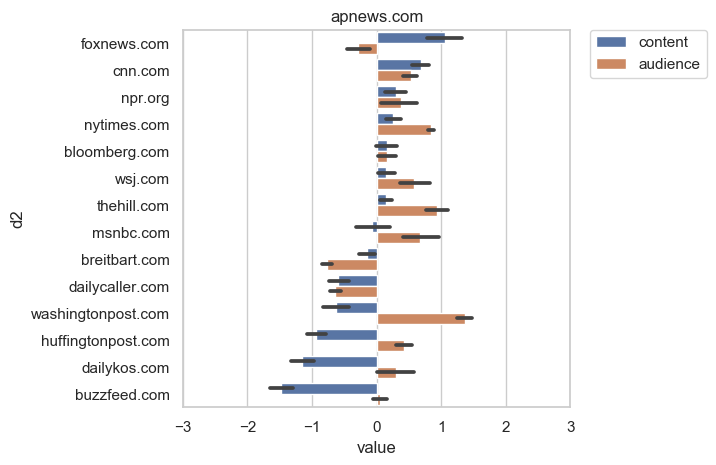

thehill.com


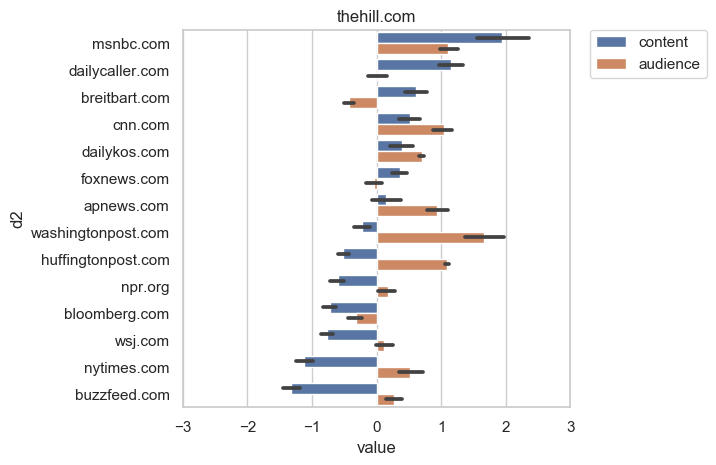

washingtonpost.com


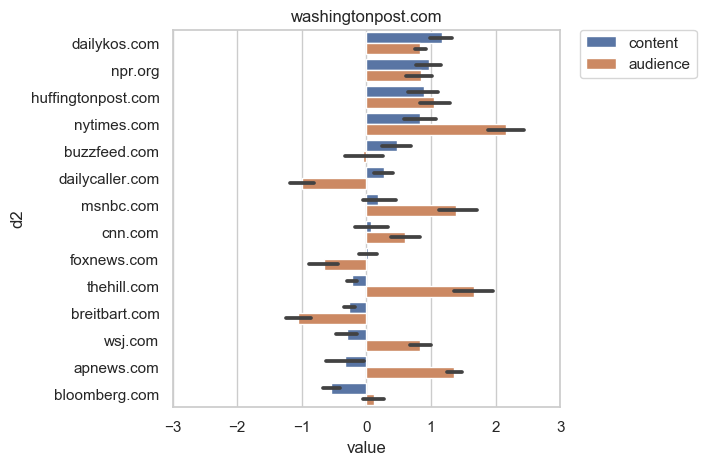

buzzfeed.com


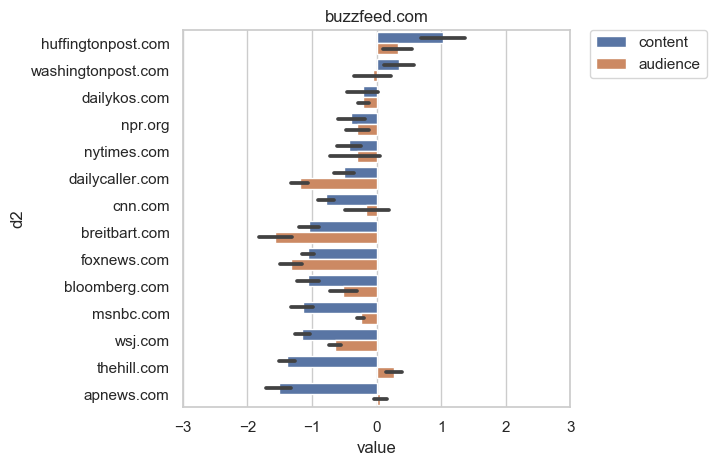

huffingtonpost.com


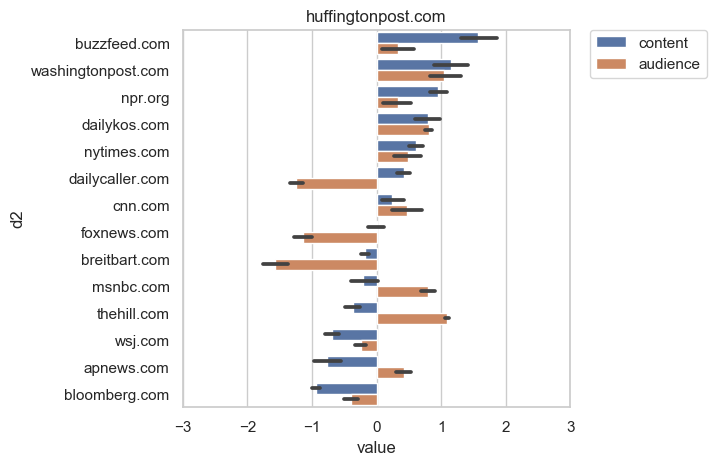

cnn.com


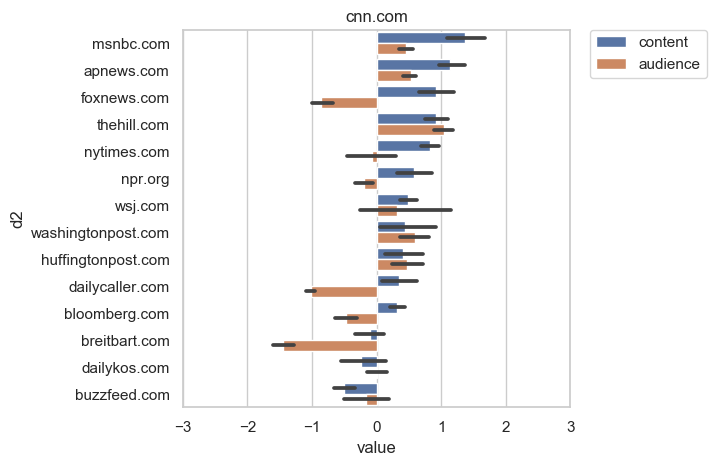

msnbc.com


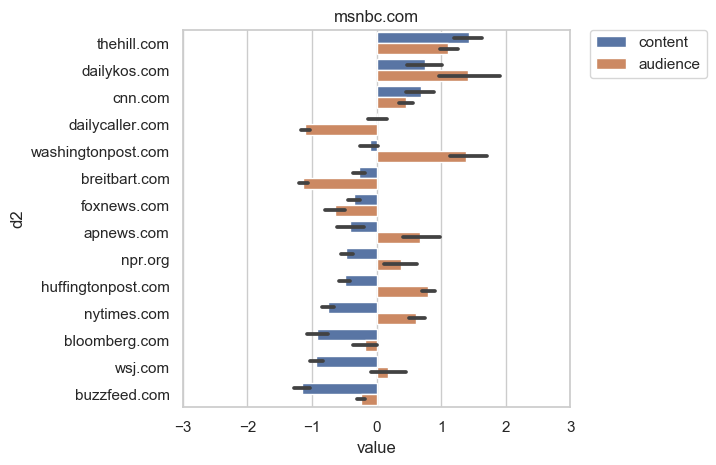

dailykos.com


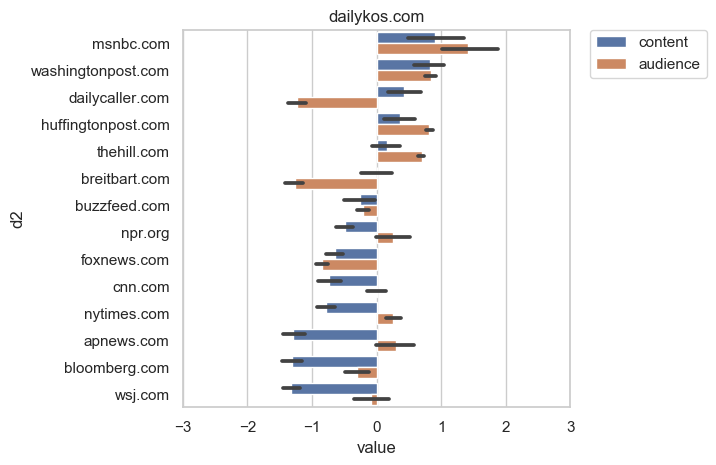

dailycaller.com


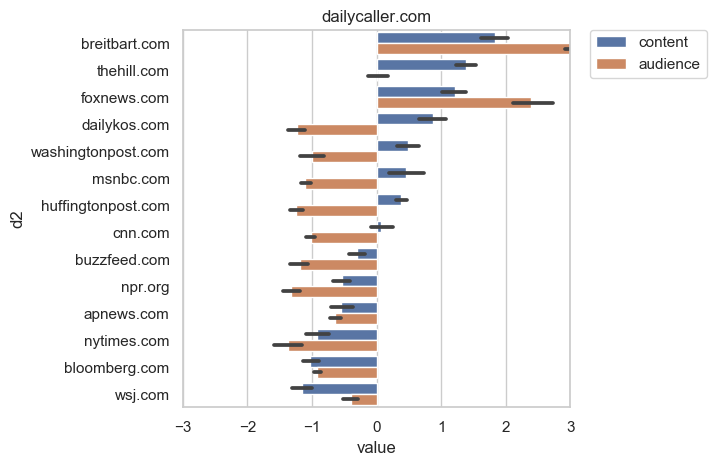

breitbart.com


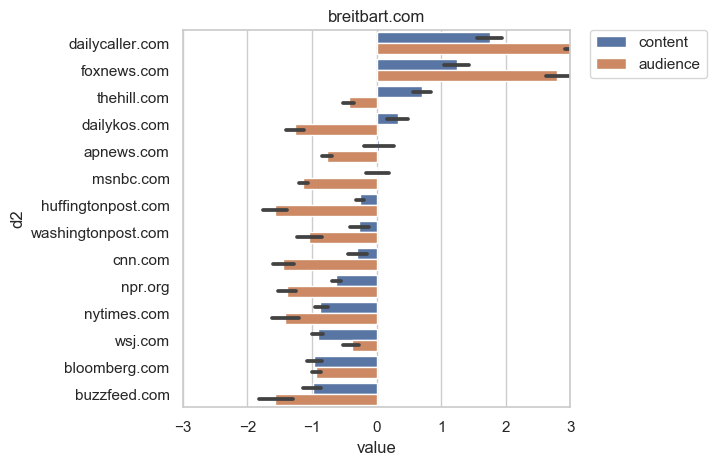

nytimes.com


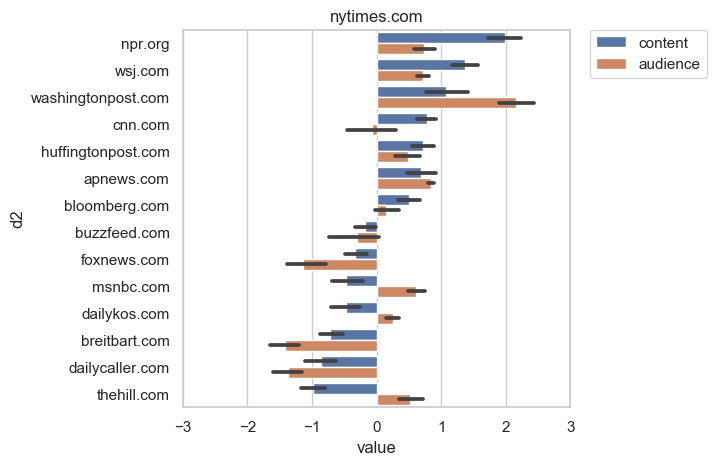

foxnews.com


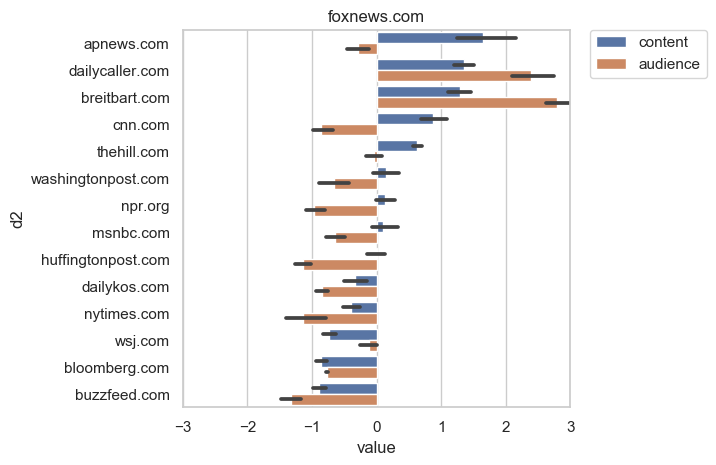

npr.org


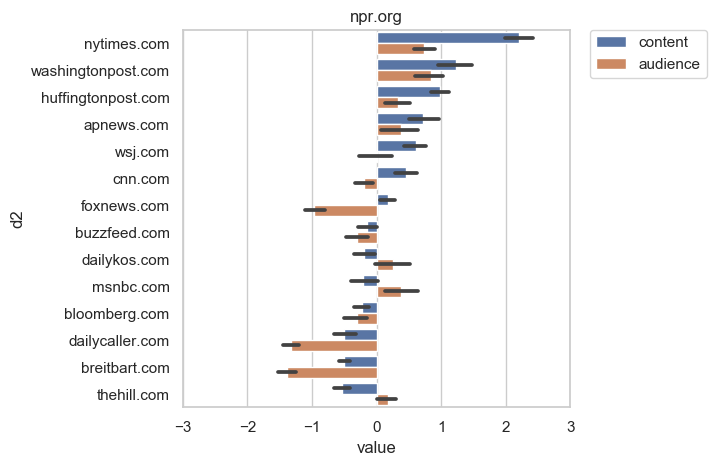

bloomberg.com


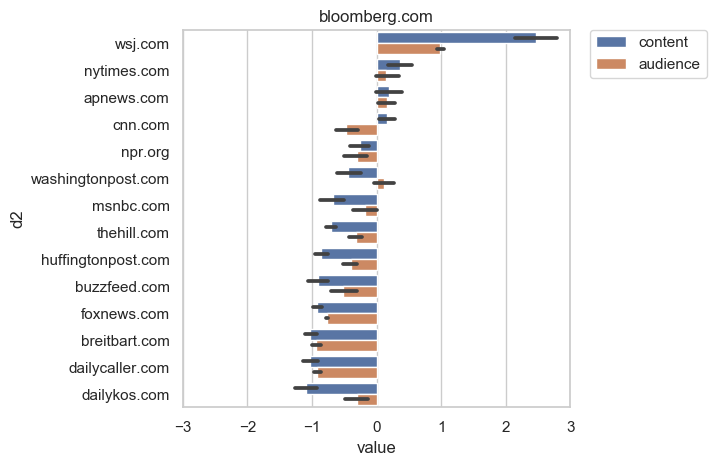

wsj.com


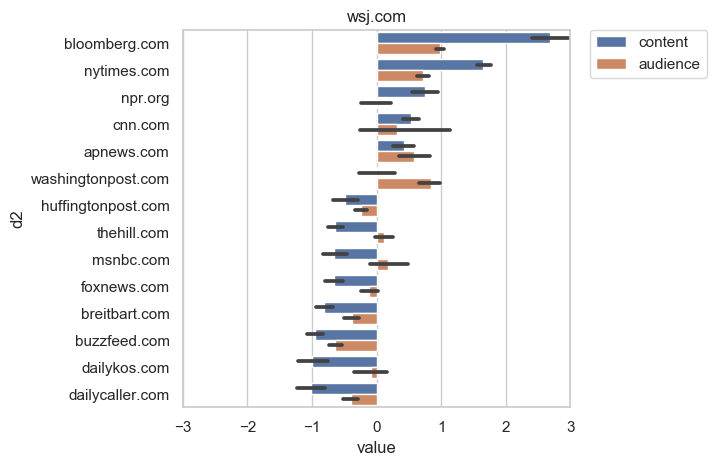

In [71]:
for d in order:
    print(d)
    slug = d.split('.')[0]
    plot_ac(d, f'figures/ca-{slug}-composite.')

In [79]:
df = dfc.merge(dfa)

In [80]:
df['c_mean'] = df.apply(lambda r: np.mean([r[col] for col in C_METRICS]), 1)

In [81]:
df['a_mean'] = df.apply(lambda r: np.mean([r[col] for col in A_METRICS]), 1)

In [82]:
df['label'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} -> {x[1]}', axis=1)

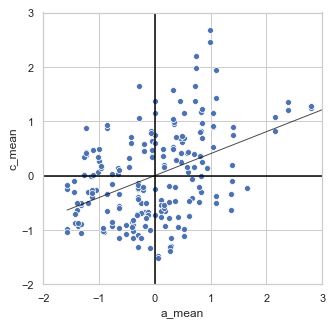

In [83]:
lr = stats.linregress(df.a_mean, df.c_mean)

fitx = np.array([df.a_mean.min(), df.a_mean.max()])
fity = lr.slope * fitx + lr.intercept

plt.figure(figsize=(5,5))
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.axhline(0, c='black')
plt.axvline(0, c='black')
ax = sns.scatterplot(x='a_mean', y='c_mean', data=df)
ax.plot(fitx, fity, c='black', linewidth=1, alpha=0.7)

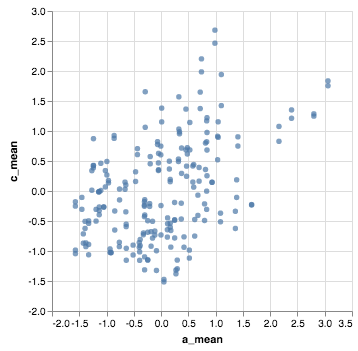

In [84]:
alt.Chart(df, width=300, height=300).mark_circle().encode(x='a_mean', y='c_mean', tooltip='label')

In [85]:
df['ca_delta'] = df.c_mean - df.a_mean

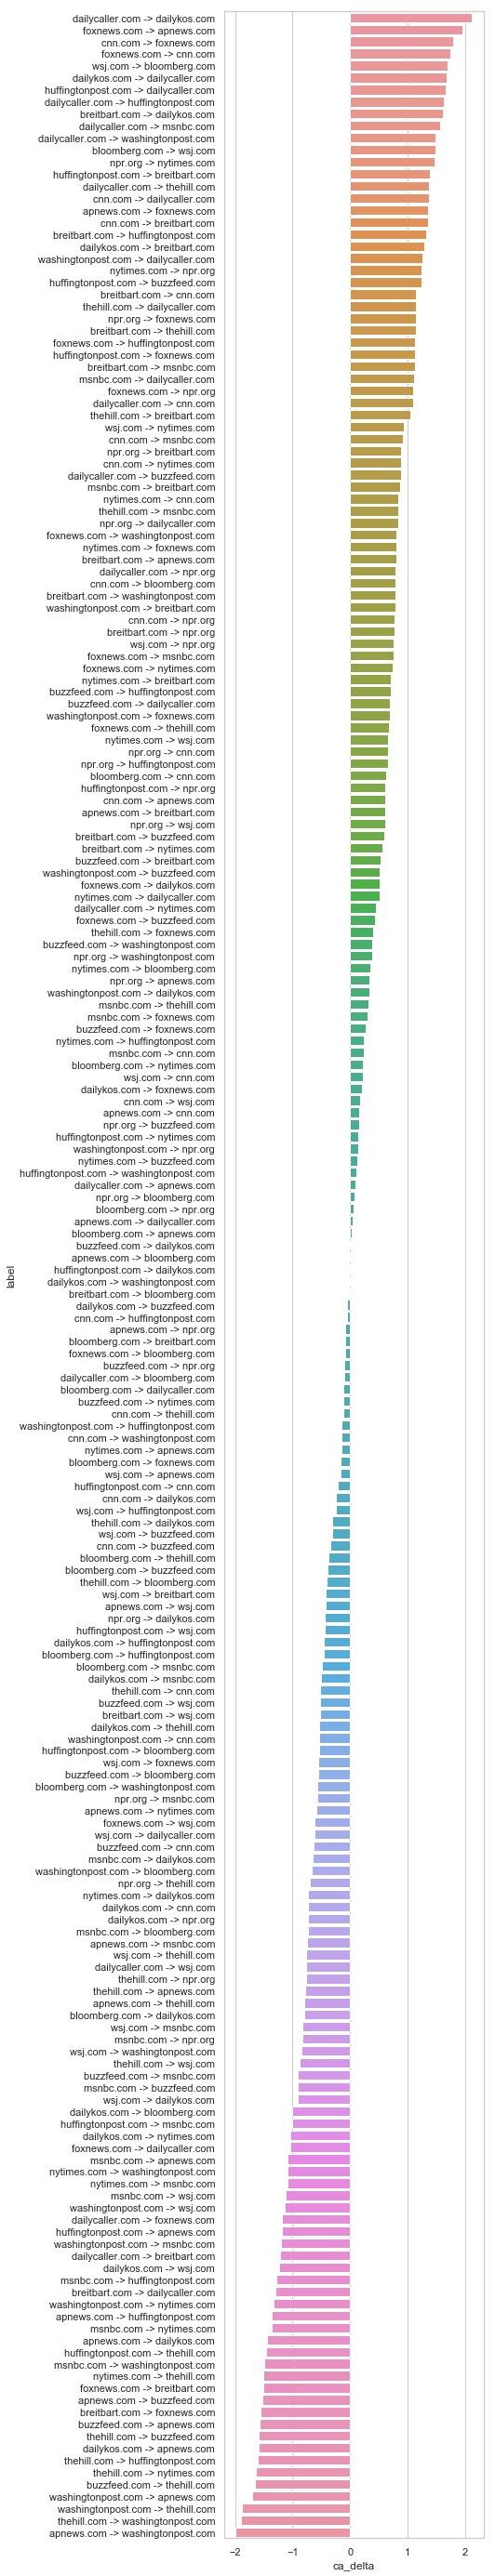

In [86]:
plt.figure(figsize=(5,50))
sns.barplot(x='ca_delta', y='label', data=df.sort_values('ca_delta', ascending=False))